In [ ]:
!pip install np_utils
!pip install tensorflow==2.0.0
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 690 kB/s 
  Created wheel for np-utils: filename=np_utils-0.6.0-py3-none-any.whl size=56459 sha256=cd014e24b607771f320b081e1689b01c89d0184b717ff694f965c90e263a7b1f
  Stored in directory: /root/.cache/pip/wheels/d2/83/71/a781667865955ae7dc18e5a4038401deb56d96eb85d3a5f1c0
Successfully built np-utils
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 86.3 MB 40 kB/s 
     |████████████████████████████████| 3.8 MB 46.5 MB/s 
     |████████████████████████████████| 449 kB 28.3 MB/s 
     |████████████████████████████████| 50 kB 6.0 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=2d194e2eb6e9b7c42d30939bb65e55d25193dc5ffe09f0d20a13b518171312f9
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da

In [ ]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
tf.compat.v1.disable_v2_behavior()
# from tensorflow.python.ops.numpy_ops import np_config

import os
import csv
import pywt
import time
import shap
import itertools
import collections
import numpy as np 
import pandas as pd 
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report,precision_score,recall_score,accuracy_score,f1_score,roc_auc_score
# np_config.enable_numpy_behavior()
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Colab_Datasets/mitbih_database/'
window_size = 180
maximum_counting = 10000

# ['N','V','/','A','F','~']#,'L','R',f','j','E','a']#,'J','Q','e','S']
# N=['N','L','R','e','j']
# S=['A','a','J','S']
# V=['V','E']
# F=['F']
# Q=['/','f','Q']

classes = ['N','L','R','e','j','A','a','J','S','V','E','F','/','f','Q']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [ ]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

In [ ]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

Total Records are : 48


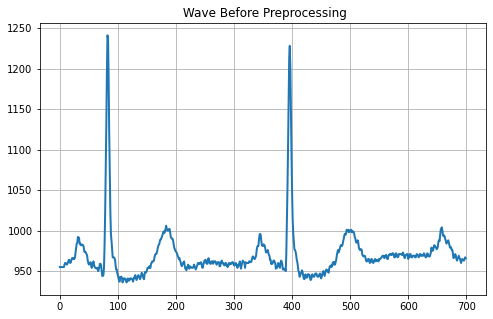

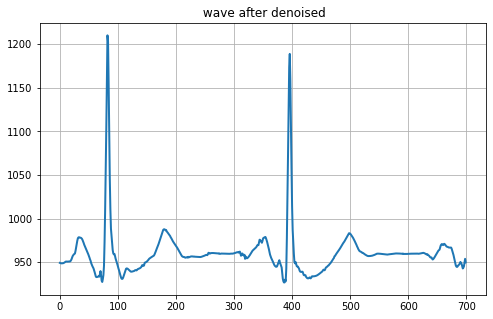

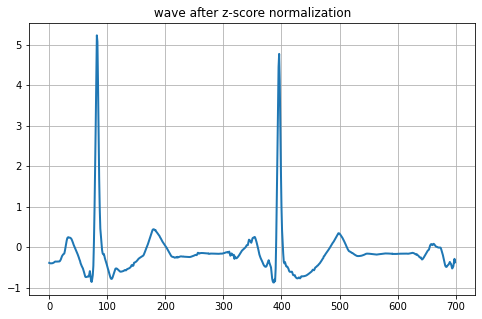

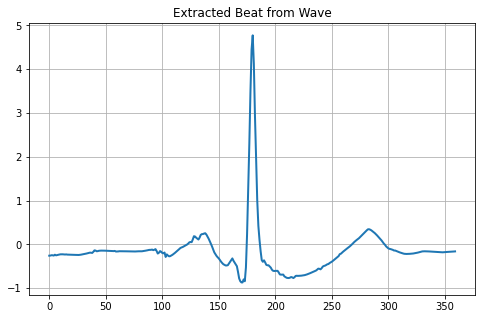

In [ ]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec

print("Total Records are :",len(records))

for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title( " Wave Before Preprocessing")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = denoise(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title( " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title( " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()
    
    #Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
#                 if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
#                     pass
#                 else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r is 1 and not example_beat_printed: 
                        plt.title("Extracted Beat from Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

In [ ]:
temp = np.array(y)
print("All classes are:",np.unique(temp))
print("Combining classes inform of AAII EC57 guidance:")
for i in range(0,len(y)):
  if y[i]==0 or y[i]==1 or y[i]==2 or y[i]==3 or y[i]==4:
    y[i]=0
  if y[i]==5 or y[i]==6 or y[i]==7 or y[i]==8:
    y[i]=1
  if y[i]==9 or y[i]==10:
    y[i]=2
  if y[i]==11:
    y[i]=3
  if y[i]==12 or y[i]==13 or y[i]==14:
    y[i]=4
print("Classes have been combined")

temp = np.array(y)
print("Combined Classes are:",np.unique(temp))


## Joining x and y
df_data=[]
for i in range(0,len(X)):
    df_data.append(np.append(X[i], y[i]))
print(np.shape(df_data))

All classes are: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Combining classes inform of AAII EC57 guidance:
Classes have been combined
Combined Classes are: [0 1 2 3 4]
(109438, 361)


# Classes Distribution

0.0    90582
4.0     8038
2.0     7235
1.0     2781
3.0      802
Name: 360, dtype: int64


<BarContainer object of 5 artists>

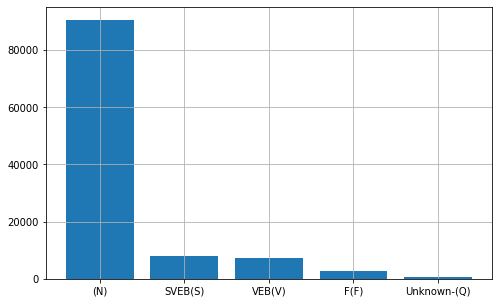

In [ ]:
df_data = pd.DataFrame(df_data)
per_class = df_data[df_data.shape[1]-1].value_counts()
per_class=pd.DataFrame(per_class).rename(index={0:'(N)',1:'SVEB(S)',2:'VEB(V)',3:'F(F)',4:'Unknown-(Q)'})
print(per_class)
plt.bar(per_class[360].index,per_class[360].values)

# Modeling

In [ ]:
x = df_data.iloc[:,:df_data.shape[1]-1].values
y = df_data.iloc[:,df_data.shape[1]-1].values

x_train,x_test,y_train,y_test = train_test_split(x, y, random_state=0, stratify=y, shuffle=True,test_size=0.20)

print("x_train and y_train shape : ", np.shape(x_train),np.shape(y_train))
print("x_test and y_test shape : ", np.shape(x_test),np.shape(y_test))

x_train and y_train shape :  (87550, 360) (87550,)
x_test and y_test shape :  (21888, 360) (21888,)


In [ ]:
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)
print(np.shape(y_train), np.shape(y_test))

(87550, 5) (21888, 5)


In [ ]:
x_train = x_train.reshape(len(x_train), x_train.shape[1],1)
x_test = x_test.reshape(len(x_test), x_test.shape[1],1)
print(np.shape(x_train), np.shape(x_test))

(87550, 360, 1) (21888, 360, 1)


In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=13, padding='same', activation='relu',input_shape=(360, 1)))
model.add(tf.keras.layers.AvgPool1D(pool_size=3, strides=2))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=15, padding='same', activation='relu'))
model.add(tf.keras.layers.AvgPool1D(pool_size=3, strides=2))
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=17, padding='same', activation='relu'))
model.add(tf.keras.layers.AvgPool1D(pool_size=3, strides=2))
# model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=19, padding='same', activation='relu'))
# model.add(tf.keras.layers.AvgPool1D(pool_size=3, strides=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(35,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
model.add(tf.keras.layers.Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
model.add(tf.keras.layers.Softmax())

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 360, 16)           224       
_________________________________________________________________
average_pooling1d (AveragePo (None, 179, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 179, 32)           7712      
_________________________________________________________________
average_pooling1d_1 (Average (None, 89, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 89, 64)            34880     
_________________________________________________________________
average_pooling1d_2 (Average (None, 44, 64)            0         
_________________________________________

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,rankdir="DR")

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

start = time.time()
history = model.fit(x_train, y_train, batch_size=36, epochs=50, verbose=1, validation_data=(x_test, y_test))
print("Total time: ", time.time() - start, "seconds")

Train on 87550 samples, validate on 21888 samples
Epoch 1/50
87550/87550 [==============================] - 113s 1ms/sample - loss: 0.1588 - acc: 0.9593 - val_loss: 0.1054 - val_acc: 0.9736
Epoch 2/50
87550/87550 [==============================] - 110s 1ms/sample - loss: 0.0902 - acc: 0.9773 - val_loss: 0.0738 - val_acc: 0.9808
Epoch 3/50
87550/87550 [==============================] - 108s 1ms/sample - loss: 0.0754 - acc: 0.9817 - val_loss: 0.0662 - val_acc: 0.9855
Epoch 4/50
87550/87550 [==============================] - 111s 1ms/sample - loss: 0.0657 - acc: 0.9845 - val_loss: 0.0654 - val_acc: 0.9842
Epoch 5/50
87550/87550 [==============================] - 109s 1ms/sample - loss: 0.0613 - acc: 0.9858 - val_loss: 0.0558 - val_acc: 0.9865
Epoch 6/50
87550/87550 [==============================] - 110s 1ms/sample - loss: 0.0569 - acc: 0.9866 - val_loss: 0.0529 - val_acc: 0.9881
Epoch 7/50
87550/87550 [==============================] - 107s 1ms/sample - loss: 0.0551 - acc: 0.9874 - val_l

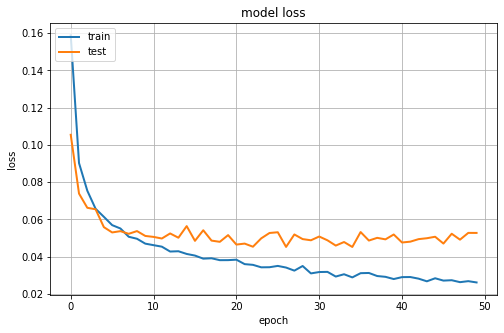

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

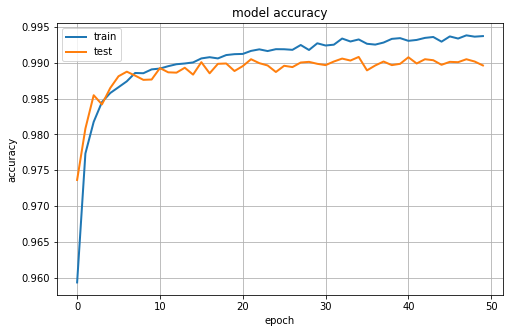

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(x_train, y_train)

print('Train Loss:', score[0])
print('Train accuracy:', score[1])

87550/87550 [==============================] - 30s 347us/sample - loss: 0.0193 - acc: 0.9956
Train Loss: 0.019321094811439243
Train accuracy: 0.99561393


In [ ]:
from sklearn.metrics import classification_report
y_pred=model.predict(x_train)
y_pred=np.argmax(y_pred, axis=1)
y_testt=np.argmax(y_train, axis=1)
print(classification_report(y_testt,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     72465
           1       0.99      0.92      0.96      2225
           2       0.98      1.00      0.99      5788
           3       0.98      0.82      0.90       642
           4       1.00      1.00      1.00      6430

    accuracy                           1.00     87550
   macro avg       0.99      0.95      0.97     87550
weighted avg       1.00      1.00      1.00     87550



In [ ]:
print("Accuracy_score of training_set:",accuracy_score(y_testt,y_pred))
print("Precision_score of training_set:",precision_score(y_testt,y_pred,average='weighted'))
print("Recall_score of training_set:",recall_score(y_testt,y_pred,average='weighted'))
print("F1_score of training_set:",f1_score(y_testt,y_pred,average='weighted'))

Accuracy_score of training_set: 0.9956139348943461
Precision_score of training_set: 0.995603730080153
Recall_score of training_set: 0.9956139348943461
F1_score of training_set: 0.9955171334301278


In [ ]:
score = model.evaluate(x_test, y_test)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

21888/21888 [==============================] - 7s 342us/sample - loss: 0.0527 - acc: 0.9896
Test Loss: 0.052683107187966025
Test accuracy: 0.98962903


In [ ]:
from sklearn.metrics import classification_report
y_pred=model.predict(x_test)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
print(classification_report(y_test,y_pred))

In [ ]:
print("Accuracy_score of testing_set:",accuracy_score(y_test,y_pred))
print("Precision_score of testing_set:",precision_score(y_test,y_pred,average='weighted'))
print("Recall_score of testing_set:",recall_score(y_test,y_pred,average='weighted'))
print("F1_score of testing_set:",f1_score(y_test,y_pred,average='weighted'))

Accuracy_score of testing_set: 0.9896290204678363
Precision_score of testing_set: 0.9894311373379511
Recall_score of testing_set: 0.9896290204678363
F1_score of testing_set: 0.9892643007065809


In [ ]:
start = time.time()

path = '/content/drive/MyDrive/Colab_Datasets/mitbih_database/'
window_size = 180
maximum_counting = 10000

# ['N','V','/','A','F','~']#,'L','R',f','j','E','a']#,'J','Q','e','S']
# N=['N','L','R','e','j']
# S=['A','a','J','S']
# V=['V','E']
# F=['F']
# Q=['/','f','Q']

classes = ['N','L','R','e','j','A','a','J','S','V','E','F','/','f','Q']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec

print("Total Records are :",len(records))

for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
          
    
    #Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
#                 if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
#                     pass
#                 else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION

                    X.append(beat)
                    y.append(arrhythmia_index)

# temp = np.array(y)
# print("All classes are:",np.unique(temp))
# print("Combining classes inform of AAII EC57 guidance:")
# for i in range(0,len(y)):
#   if y[i]==0 or y[i]==1 or y[i]==2 or y[i]==3 or y[i]==4:
#     y[i]=0
#   if y[i]==5 or y[i]==6 or y[i]==7 or y[i]==8:
#     y[i]=1
#   if y[i]==9 or y[i]==10:
#     y[i]=2
#   if y[i]==11:
#     y[i]=3
#   if y[i]==12 or y[i]==13 or y[i]==14:
#     y[i]=4
# print("Classes have been combined")

X=(pd.DataFrame(X)).values
X = X.reshape(len(X), X.shape[1],1)


dummy=model.predict(X)

print("Total time taken for prediction: ", time.time() - start, "seconds")
print("Total time taken for prediction of 1 sample: ", (time.time() - start)/len(X), "seconds")
print("Total time taken for prediction of 1 Patient: ", (time.time() - start)/48, "seconds")

In [ ]:
background = x_train[:100].astype(np.float32)
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(x_test[:10])


In [ ]:
plt.plot(x_test[1])
plt.title("Normal")
plt.xlabel("time(ms)")
plt.ylabel("Normalized Magnitude(Amplitude)")
plt.show()

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], x_test[1])

In [ ]:
plt.plot(x_test[9])
plt.title("Supra Ventricular Beat")
plt.xlabel("time(ms)")
plt.ylabel("Normalized Magnitude(Amplitude)")
plt.show()

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], x_test[9])